In [2]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /home/vadim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture6.pdf" target="_blank">презентацию</a>, [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html) по RNN и [ноутбук](https://miptstats.github.io/courses/ad_fivt/nlp_sem_llama.html) по генерации текста.

---
### Задача 1. Предсказание заработной платы


В этой задаче вам предлагается решить задачу регрессии &mdash; по текстовому описанию вакансии определить заработную плату. Для решения такой задачи можно применять различные методы, в том числе и те, которые были рассмотрены на лекции.
Мы будем решать эту задачу с помощью рекуррентной нейронной сети.

Датасет `salary_dataset.csv` лежит по <a target="_blank" href="https://drive.google.com/file/d/1Q3lCw_8Uad_OzHCjvLeYRvamXR74UPbW/view?usp=sharing">ссылке</a> (312.3 MB).

Если вы работаете локально:

> Просто скачайте этот файл и укажите пути к ним ниже.


Если вы используете <a target="_blank" href="https://colab.research.google.com/">Colab</a>:
> **Скачивать файл не обязательно**. Просто подключитесь к Google Drive:
>
> ```
> from google.colab import drive
> drive.mount('/content/drive/')
> ```
>
> Перейдите по ссылке файла и добавьте shortcut на него в ваш собственный диск:
> 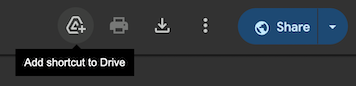

Скачаем данные для обучения и тестирования:

In [4]:
dataset = pd.read_csv('salary_dataset.csv')
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


Каждая строка содержит полное описание вакансии и соответствующую зарплату. При этом описания могут быть довольно длинными, например:

In [5]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

Для данной задачи нам не будут нужны служебные части речи и знаки пунктуации. Зададим токенизатор, списки стоп-слов и пунктуации.

In [6]:
# Зададим токенизаторы
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

Подготовьте словарь, оставив в нем только наиболее часто встречающиеся токены. Не забудьте предварительно убрать из предложений знаки пунктуации и стоп-слова.

*Можно использовать код с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).*

In [7]:
# зададим счетчики
counter = Counter()

# посчитаем количество вхождений каждого токена
for text in dataset["FullDescription"]:
    counter.update(
        token
        for token in tokenizer(text)
        if token not in stop_words and token not in punc
    )

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))

Этот упорядоченный словарь хранит слово и его встречаемость. Можно посмотреть на самые частые слова в датасете:

In [8]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 269289),
 ('The', 258645),
 ('role', 211475),
 ('work', 207318),
 ('team', 194087),
 ('This', 180149),
 ('within', 175173),
 ('You', 173743),
 ('skills', 162215)]

Теперь изменим словарь, добавив в него специальные токены, которые необходимы для подготовки данных к обучению:

In [9]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)

Подготовим класс датасета:

In [10]:

class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

Допишите функцию для дополнения текста до максимальной длины в батче. Снова воспользуйтесь кодом с [семинара](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

*Обратите внимание, что теперь вместо целочисленных меток мы используем вещественные таргеты. Если не поменять код с семинара, то вы можете решать неправильную задачу.*

In [11]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и таргетов, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX

    Вход:
    * batch — батч с текстами и таргетами

    Возвращает:
    * texts_tensors - список тензоров текстов из батча, дополненных паддингом
    * target - список соответствующих меток батча
    """
    texts, target = zip(*batch)
    target = torch.FloatTensor(target)

    texts_tensors = pad_sequence(
        [torch.LongTensor(t) for t in texts], padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target

Токенизируем текст, а таргет переведем во `float`.

In [12]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

Каждому из текстов в датасете сопоставляется последовательность токенов, причем везде разного размера:

In [13]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  6, 25000, 25000, 141, 18, 25000, 25000, 3605, 25000, 35, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  67, 12, 25000, 14, 25000, 25000, 4674, 393, 871, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  573, 186, 1517, 658, 0, 24450, 25000, 15730, 13311, 87, ...
Таргет: 72098.0 



При решении задач регрессии с помощью нейросетей удобнее всего бывает перевести предсказываемые значения в небольшой диапазон, например, от 0 до 1. Это нужно, чтобы повысить численную стабильность обучения &mdash; не нагружать модель большими значениями таргетов. В нашей задаче это важно, ведь зарплата может иметь большой разброс и принимать большие значения.

Чтобы сделать это, воспользуемся преобразованием `MinMaxScaler` из библиотеки `sklearn`, которое мы рассматривали в [задаче 3 задания 3](https://miptstats.github.io/courses/ad_fivt/task3.html#%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0-3.).
Таким образом, мы получим значения, удобные для использования при обучении.

In [14]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)

(150000, 50000)

Посмотрим на отмасштабированные значения зарплаты:

In [15]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.1538, 0.359, 0.1154, ...


Сформируйте даталоадеры для обучения и валидации.

In [16]:
BATCH_SIZE = 64  # размер батча

# сформируем даталоадеры
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

Наконец, можем подготовить модель. Будем использовать рекуррентную архитектуру, подобную той, что была на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.ipynb).
Отличие состоит в том, что теперь мы предсказываем не метку класса, а вещественный таргет. Подумайте, какую часть сети нужно изменить, чтобы адаптировать ее к нашей задаче.

In [17]:
class SimpleRNNRegressor(nn.Module):
    """ Модель для регрессии на основе LSTM"""

    def __init__(
        self,
        num_tokens,
        emb_size=512,
        rnn_num_units=64,
        output_dim=1, 
        num_layers=1
    ):
        """
        1) num_tokens — общее количество токенов,
        2) emb_size — размер эмбеддингового пространства,
        3) rnn_num_units - размер пространства скрытых представлений в rnn,
        4) output_dim - размерность выхода-предсказания.
        """
        super(self.__class__, self).__init__()

        # ==========================================================
        self.emb = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.LSTM(input_size=emb_size, hidden_size=rnn_num_units, batch_first=True, num_layers=num_layers)
        self.classifier = nn.Linear(rnn_num_units, output_dim)
        # ==========================================================

    def forward(self, x):
        """
        * x — общее количество токенов.

        Возвращает:
        * predictions - предсказания модели.
        """

        # ==========================================================
        # x.shape = (batch_size, max_pad_len)

        # Получим эмбеддинги для входов
        # (batch_size, max_pad_len, emb_size)
        emb = self.emb(x)

        # Прогоним через RNN-сеть и получим скрытое состояние,
        # в котором хранится нужная информация о последовательности
        # (batch_size, rnn_num_units)
        _, (h_state, _) = self.rnn(emb)

        # Прогоним через полносвязный слой и получим логиты для каждого токена
        # (batch_size, num_tokens)
        predictions = self.classifier(h_state.squeeze(0))
        # ==========================================================

        return predictions

Так как теперь решаем задачу регрессии, вместо точности модели будем измерять среднеквадратичную ошибку:

In [18]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

Допишите функции для обучения и валидации. Они почти не будут отличаться от тех, что были на [семинаре](https://miptstats.github.io/courses/ad_fivt/nlp_sem.html).

In [19]:
def train(model, iterator, optimizer, criterion, train_loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её ошибки.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0
    model.train()

    # Проход по всему датасету
    for batch_id, batch in enumerate(iterator):
        # Обучение на 1 батче, подсчет метрики
        # ==========================================================
        #  чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        mse_result = mse(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_mse += mse_result.item()
        train_loss_history.append(loss.item())
        # ==========================================================

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_mse = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        # Проход по всему датасету
        for batch_id, batch in enumerate(iterator):
            # ==========================================================
            # Обучение на 1 батче, подсчет метрики
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            # получим предсказания
            predictions = model(texts).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, labels)
            mse_result = mse(predictions, labels)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_mse += mse_result.item()
            if val_loss_history is not None:
                val_loss_history.append(loss.item())
            # ==========================================================

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Теперь определим итоговую функцию для всего цикла обучения:

In [20]:
def visualize_epoch(epoch, start_time, loss_history, mse_history):
    """
    Функция для визуализации 1 эпохи.

    Параметры.
    1) epoch — номер эпохи,
    2) start_time — время начала эпохи,
    3) loss_history - tuple истории лосса на train и test,
    4) mse_history - tuple истории MSE на train и test.
    """
    # Посчитаем время работы одной эпохи
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Отобразим графики лоссов
    clear_output(True)
    plt.figure(figsize=(18, 6))

    train_loss_history, val_loss_history = loss_history
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history)
    plt.title("Train Loss")
    plt.xlabel("Номер батча")
    plt.subplot(1, 3, 2)
    plt.plot(val_loss_history, color="tab:orange")
    plt.title("Valid Loss")
    plt.xlabel("Номер батча")

    # Отрисуем значение MSE от эпохи
    train_mse_history, val_mse_history = mse_history
    plt.subplot(1, 3, 3)
    plt.plot(train_mse_history, label="Train")
    plt.plot(val_mse_history, label="Valid")
    plt.legend()
    plt.title("MSE")
    plt.xlabel("Номер эпохи")
    plt.show()

    print(
        f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
    )


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    train_loss_history = []
    val_loss_history = []
    train_mse_history = []
    val_mse_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_mse = train(
            model_instance,
            train_loader,
            optimizer,
            criterion,
            train_loss_history,
        )
        train_mse_history.append(train_mse)

        # Оценим ошибку модели на тестовом датасете
        valid_loss, valid_mse = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_mse_history.append(valid_mse)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Визуализируем результаты эпохи
        visualize_epoch(
            epoch,
            start_time,
            (train_loss_history, val_loss_history),
            (train_mse_history, val_mse_history),
        )

In [22]:
# У нас задача регрессии, будем использовать MSELoss
criterion = nn.MSELoss()
history = []

# Задайте параметры сети
model = SimpleRNNRegressor(
    num_tokens=len(vocab),
    emb_size=256,
    rnn_num_units=8,
    output_dim=1,
    num_layers=10,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# Посмотрите на получившуюся модель
model

SimpleRNNRegressor(
  (emb): Embedding(25002, 256, padding_idx=25001)
  (rnn): LSTM(256, 8, num_layers=10, batch_first=True)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

Обучите несколько моделей с различными гиперпараметрами (например, шаг обучения, размер словаря, архитектура) и сравните их качество на тестовой выборке.

*Не пугайтесь, если у вас не будет получаться хорошее качество на валидации: решаемая задача довольно сложная, а RNN &mdash; достаточно простая архитектура. Но постарайтесь, чтобы модель хотя бы не вырождалась в константу. Для этого следите за переобучением!*

*На 3 курсе вы сможете познакомиться с моделями, которые решают такую задачу гораздо лучше.*

### Модель 1
    model = SimpleRNNRegressor(
        num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=16,
        output_dim=1,
        num_layers=1,
    )

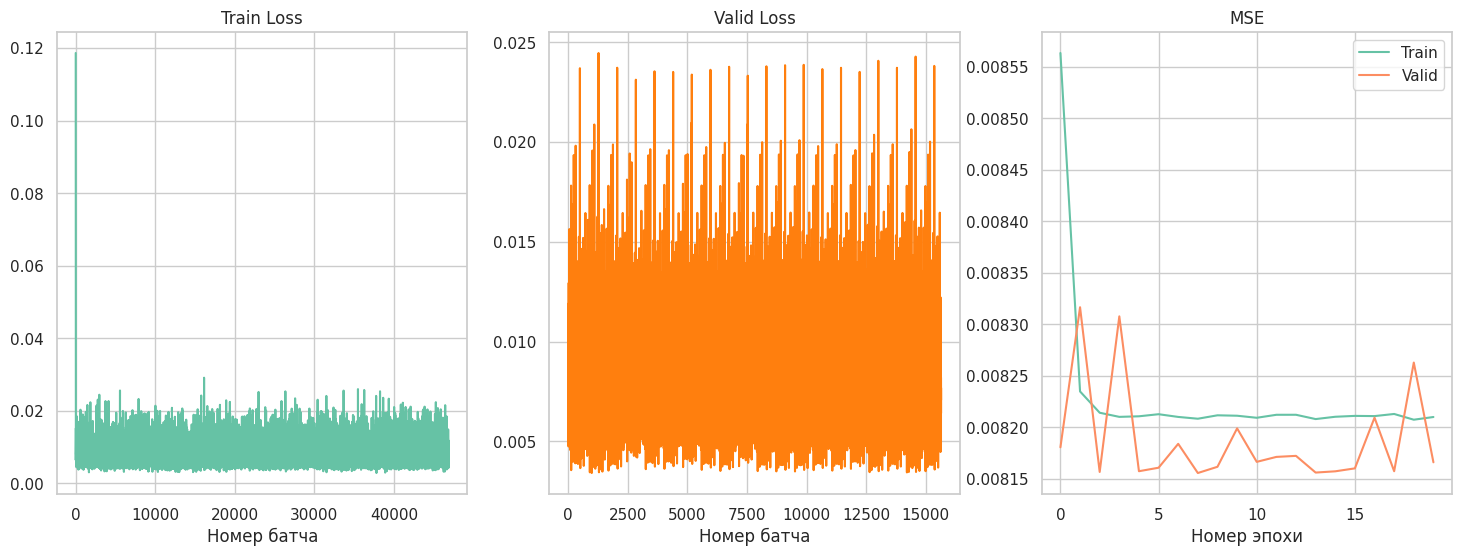

Номер эпохи: 20 | Время обучения эпохи: 0m 17s


In [25]:
training_loop(model, n_epochs=20)

Видно, что при одном слое в обучении все плохо и модель практически не обучается.

### Модель 2
    model = SimpleRNNRegressor(
        num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=16,
        output_dim=1,
        num_layers=5,
    )

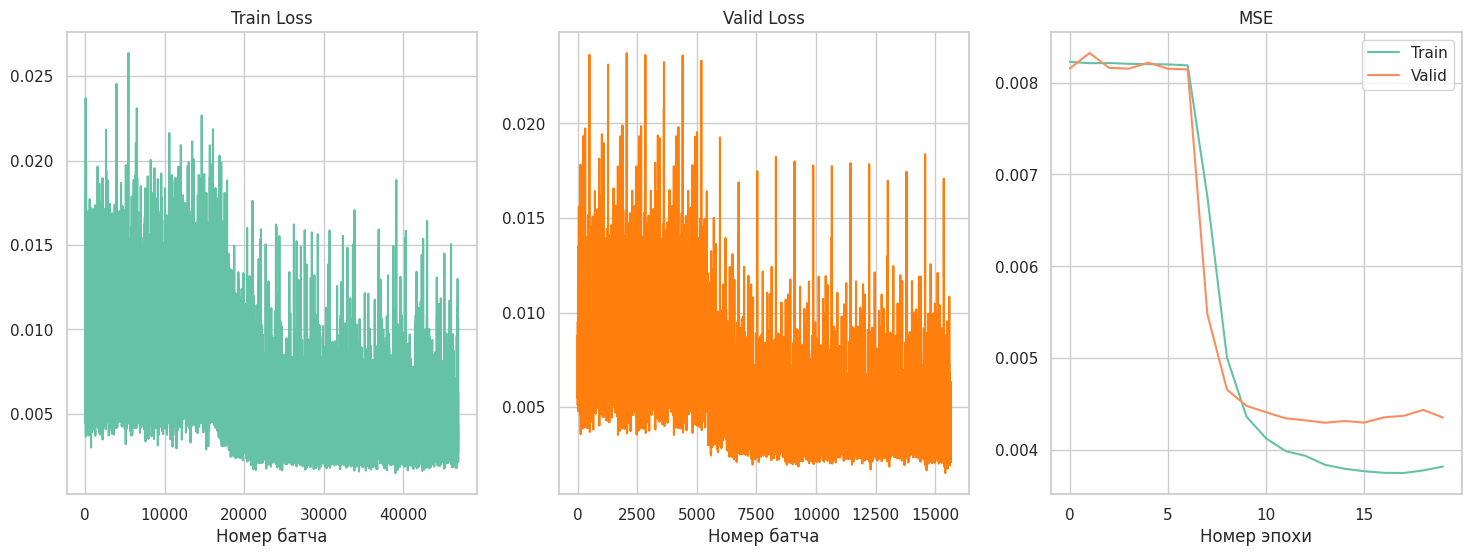

Номер эпохи: 20 | Время обучения эпохи: 0m 28s


In [30]:
training_loop(model, n_epochs=20)

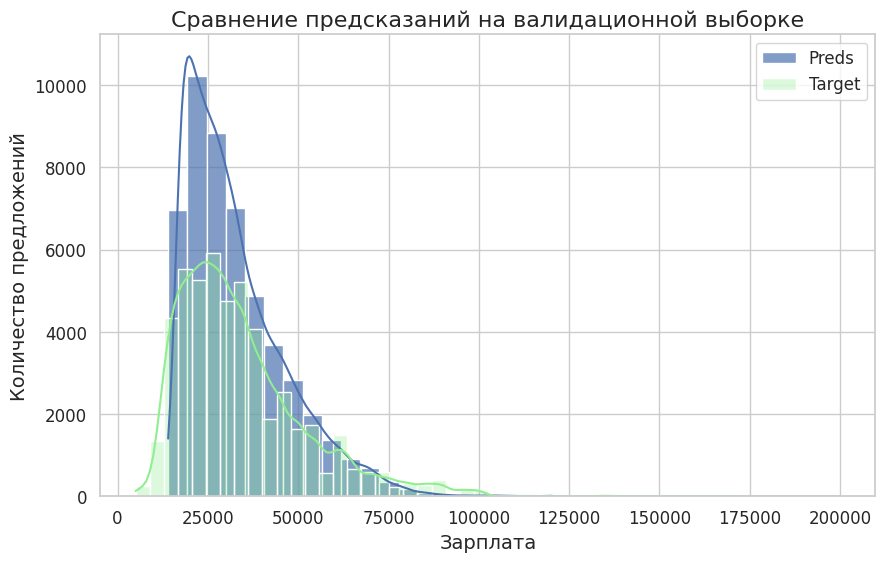

In [31]:
all_preds = np.ndarray((0, 1))
with torch.no_grad():
    for batch_id, batch in enumerate(valid_loader):
        texts, targets = batch
        texts, targets = texts.to(device), targets.to(device)
        preds = model(texts).squeeze(1)
        all_preds = np.concatenate((all_preds, preds.cpu()[-1,:,:]))
    
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(scaler.inverse_transform(all_preds.reshape(-1, 1)), color='red', bins=20, alpha=0.7, label='Preds', kde=True)
sns.histplot(valid_target, color='lightgreen', bins=50, alpha=0.3, label='Target', kde=True)

plt.xlabel('Зарплата', fontsize=14)
plt.ylabel('Количество предложений', fontsize=14)
plt.title('Сравнение предсказаний на валидационной выборке', fontsize=16)

plt.legend(fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

### Модель 3
    model = SimpleRNNRegressor(
        num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=8,
        output_dim=1,
        num_layers=5,
    )

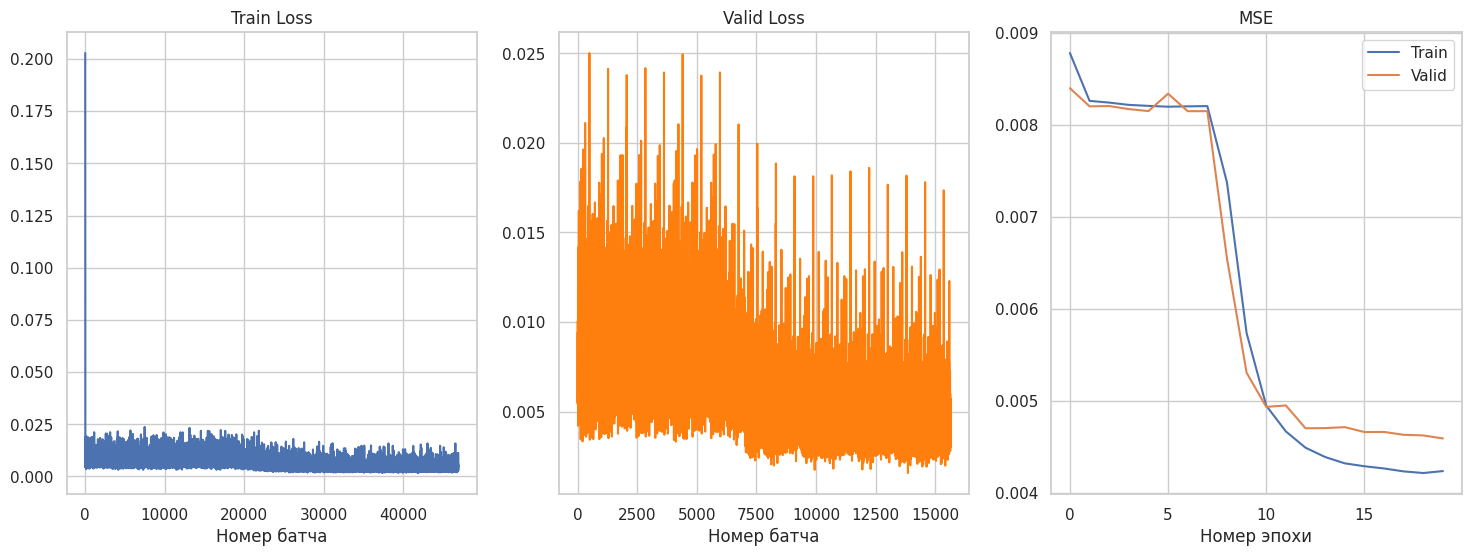

Номер эпохи: 20 | Время обучения эпохи: 0m 27s


In [33]:
training_loop(model, n_epochs=20)

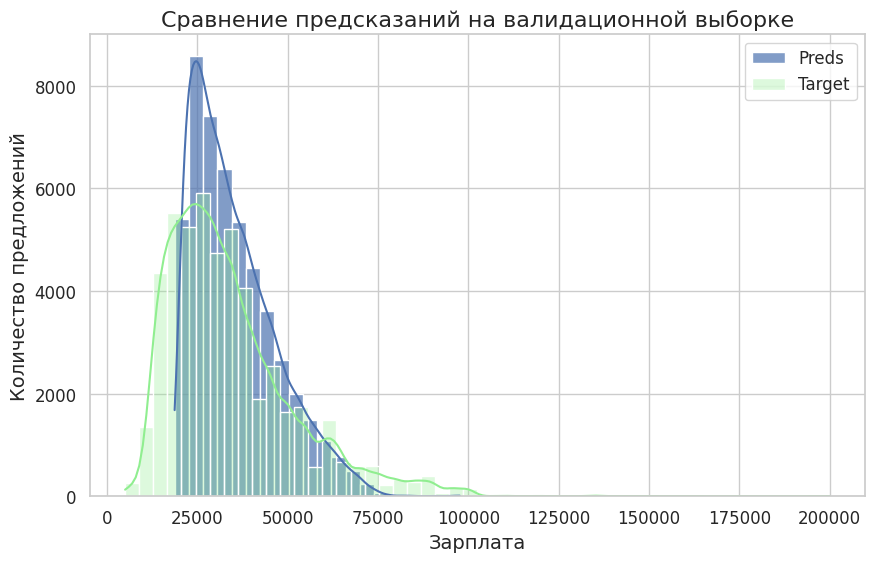

In [34]:
all_preds = np.ndarray((0, 1))
with torch.no_grad():
    for batch_id, batch in enumerate(valid_loader):
        texts, targets = batch
        texts, targets = texts.to(device), targets.to(device)
        preds = model(texts).squeeze(1)
        all_preds = np.concatenate((all_preds, preds.cpu()[-1,:,:]))

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(scaler.inverse_transform(all_preds.reshape(-1, 1)), color='red', bins=20, alpha=0.7, label='Preds', kde=True)
sns.histplot(valid_target, color='lightgreen', bins=50, alpha=0.3, label='Target', kde=True)

plt.xlabel('Зарплата', fontsize=14)
plt.ylabel('Количество предложений', fontsize=14)
plt.title('Сравнение предсказаний на валидационной выборке', fontsize=16)

plt.legend(fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

### Модель 4
    model = SimpleRNNRegressor(
        num_tokens=len(vocab),
        emb_size=256,
        rnn_num_units=8,
        output_dim=1,
        num_layers=10,
    )

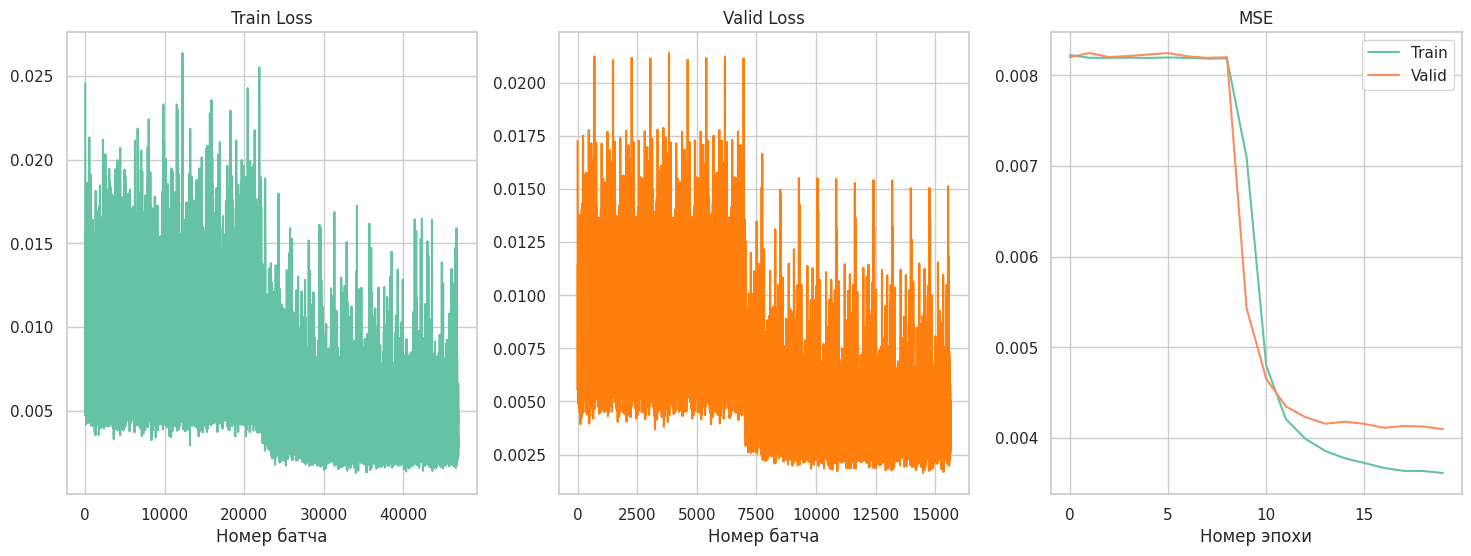

Номер эпохи: 20 | Время обучения эпохи: 0m 39s


In [23]:
training_loop(model, n_epochs=20)

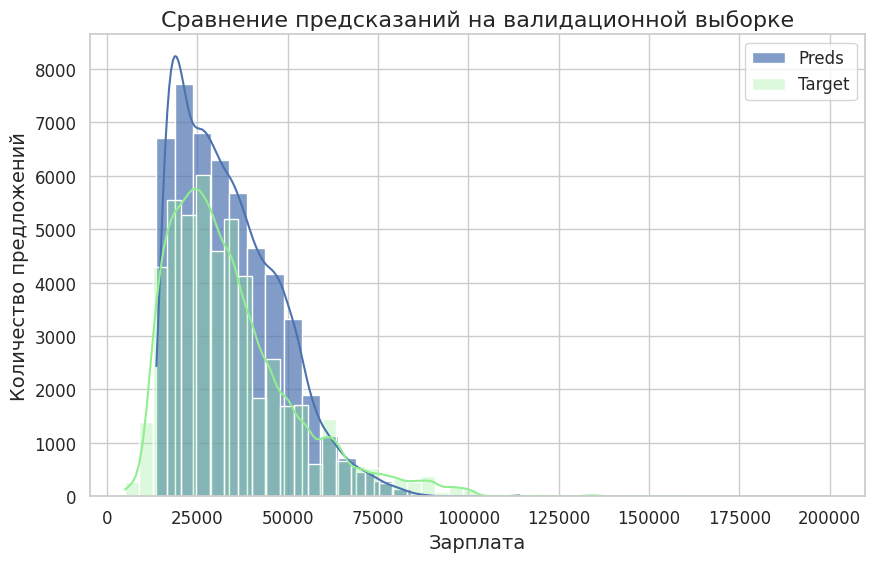

In [24]:
all_preds = np.ndarray((0, 1))
with torch.no_grad():
    for batch_id, batch in enumerate(valid_loader):
        texts, targets = batch
        texts, targets = texts.to(device), targets.to(device)
        preds = model(texts).squeeze(1)
        all_preds = np.concatenate((all_preds, preds.cpu()[-1,:,:]))

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(scaler.inverse_transform(all_preds.reshape(-1, 1)), color='red', bins=20, alpha=0.7, label='Preds', kde=True)
sns.histplot(valid_target, color='lightgreen', bins=50, alpha=0.3, label='Target', kde=True)

plt.xlabel('Зарплата', fontsize=14)
plt.ylabel('Количество предложений', fontsize=14)
plt.title('Сравнение предсказаний на валидационной выборке', fontsize=16)

plt.legend(fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

Выведите несколько примеров работы на тестовой выборке: текст вакансии, предсказание вашей модели и истинное значение зарплаты. Чтобы вернуть все значения к изначальным масштабам, используйте `scaler.inverse_transform(...)`. Также посчитайте MSE на всей тестовой выборке.

In [25]:
model.load_state_dict(torch.load('model_checkpoint.pt'))

<All keys matched successfully>

In [30]:
idxs = np.random.choice(len(dataset.index), 10)
i=0
with torch.no_grad():
    for idx in np.array(dataset.index)[idxs]:
        i+=1
        text, target = dataset.loc[idx]
        tokens = vocab(tokenizer(text))
        tokens = torch.LongTensor(tokens).to(device)
        output = model(tokens).squeeze(1)
        pred = scaler.inverse_transform(output.cpu()[-1].reshape(1, -1))
        print(f'Пример {i}'+'='*40+'\n')
        print(f'Текст вакансии: {text[:200]}...')
        print(f'Истинное значение: {target}')
        print(f'Предсказание модели: {int(pred.item())}\n')

Пример 1========================================

Текст вакансии: An opportunity has arisen for a Senior Project Officer in the Research and Enterprise Support department (RES). RES is responsible for providing specialist support services to develop the University s...
Истинное значение: 32919
Предсказание модели: 35359

Пример 2========================================

Текст вакансии: 2nd Line Support/Dorset/****  **** Our client who are an IT Service provider are looking for an experienced 2nd Line Support Technician to join their team in Dorset. The successful 2nd Line Support Te...
Истинное значение: 26000
Предсказание модели: 27589

Пример 3========================================

Текст вакансии: Infrastructure Desktop Technician  URGENT. Salary **** pro rata. Fixed term contract till the end of September 2013. Immediate start. A leading education body are looking for an experienced Infrastruc...
Истинное значение: 25500
Предсказание модели: 32440

Пример 4=======================

In [38]:
mse_value = evaluate(model, valid_loader, criterion)[0]
mse_value

/tmp/ipykernel_125960/4289008314.py:10: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([10, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(preds, y, reduction="mean")
/tmp/ipykernel_125960/4289008314.py:10: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([10, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(preds, y, reduction="mean")


0.004097212513145345

Итого MSE на валидационной выборке после обучения на 20 эпохах: ~0.0041

**Вывод:**

Нам удалось воспользоваться RNN для решения задачи прогнозирования зарплаты из описания работы.

Из рассмотрения моделей с разными параметрами можно заметить следующее:

1. На качество обучения сильно влияет количество слоев у модели. При большем количестве слоев модель выдает лучший результат
2. Количество эпох не должно быть слишком маленьким, так как тогда модель не успеет нормально обучиться. Но делать их количество слишком большим тоже не слишком помогает, так как в какой-то момент (для нашей модели это где-то 11 эпоха) модель начнет переобучаться и улучшений больше не будет. 

---
### Задача 2. Использование большой языковой модели


Ваша задача &mdash; применить <a target="_blank" href="https://llama-2.ai/">Llama 2</a> к предыдущей задаче и заставить ее предсказать заработную плату по текстовому описанию. Существует мало русскоязычных моделей, способных решить такую задачу и помещающихся в <a target="_blank" href="https://colab.research.google.com/">Colab</a>, поэтому вам придется писать запросы на английском!

In [ ]:
!pip install bitsandbytes==0.41.1 transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2  > null
import transformers
import bitsandbytes as bnb

assert torch.cuda.is_available(), "для этой части понадобится GPU"

Дисклеймер: *использовать LLM в рамках ограничений Colab хоть и возможно, но очень трудно.*

> Так как процесс генерации очень хрупкий и может сломаться при любом неверном движении, мы настоятельно рекомендуем **сохранить результаты предыдущего задания в отдельном файле** и приступать к этой задаче в самом конце. Решения задач можно сдавать в бот разными файлами.

> Если у вас возникла ошибка `Out of memory`, перезапустите ноутбук и попробуйте снова. Да, языковые модели без своей GPU &mdash; это тяжело...





От вас требуется подобрать такой промпт, который приводил бы к нужному выводу модели. Можете экспериментировать с параметрами генерации, список которых можно посмотреть в <a target="_blank" href="https://github.com/huggingface/transformers/blob/c4d4e8bdbd25d9463d41de6398940329c89b7fb6/src/transformers/generation_utils.py#L101">исходнике</a>.

Существуют различные техники, которые могут помочь вам "разговорить" языковую модель. О многих из них вы сможете прочитать <a target="_blank" href="https://docs.mistral.ai/guides/prompting-capabilities/">здесь</a>. В нашем случае полезным может быть метод Few-Shot Learning, который заключается в предоставлении модели нескольких примеров.

In [ ]:
model_name = "TheBloke/Llama-2-13B-GPTQ"

# Загружаем Llama токенизатор
tokenizer = transformers.LlamaTokenizer.from_pretrained(
    model_name, device_map=device
)
tokenizer.pad_token_id = tokenizer.eos_token_id

# И саму модель Llama
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    offload_state_dict=True,
)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
prompt = '''Your task is to predict salary based on a job text description.

            ###
            Here are some examples:
            Description: Our client is looking for a .net web developer with strong experience of of developing webbased applications using ASP.NET, JavaScript, AJAX, XML, XSLT and CSS.
            You will be able to design/develop and maintain databases using SQL and stored producers. You will have excellent problem solving skills and able to manage
            projects to tight declines. This is an excellent development role with great career progression
            Salary: 27500

            Description: ACADEMIC APPOINTMENTS A large secondary school in Leeds is seeking a teacher of Science for a long term position ,
            potentially starting immediately . The school have fantastic new facilities, and are looking for an innovative, confident and dedicated practitioner, who will help
            them on the road to becoming Outstanding. All candidates require a recognised teaching qualification, and should be able to demonstrate recent experience in
            delivering Chemistry and Biology to GCSE. Academic Appointments is committed to safeguarding and promoting the welfare of children and young people. All posts
            are subject to an enhanced CRB check and referencing.
            Salary: 32400

            Description:
            Head of User Experience  c. ****k / London A Head of User Experience / Senior Information Architect / Senior UX Consultant is required to drive forward the success
            of the websites for one of the UK's largest newspaper publishers. This is an excellent opportunity for a Head of User Experience / Senior Information Architect / Senior UX
            Consultant to take real control of the User Experience within the company, building the processes and standards, implementation and training, with the long term view being
            to build a UX team within the company. The Head of User Experience / Senior Information Architect / Senior UX Consultant will be responsible for: Building and implementing
            all UX processes, wireframes and relevant documentation Working with various internal stakeholders on the education of UX, its purpose and how it will contribute within the
            company Developing various user experiences for a variety of platforms, including mobile, apps and websites Ownership of the user experience project lifecycle, from users to
            deliverables, including types, scenarios, journeys, wireframes etc. Running user experience activities on complex, multiple work stream projects
            The Head of User Experience / Senior Information Architect / Senior UX Consultant must: Have extensive UX / IA experience, preferably within an online content
            driven / eCommerce environment Proven experience of running projects, including multiple work streams Be experienced in using the various technologies and software
            platforms involved, including HTML, Javascript, Flash, CSS & CMS Be skilled in wireframing, including the use of relevant design tools Have ideally worked within an
            Agile environment Be a self starter with a good appreciation of business and commercial values Have excellent communication skills and be able to transmit this across
            various stakeholders The role offers significant career progression and the opportunity to take control of the UX function with a view to building and leading a UX team
            in the near future. The company offers an excellent package, including pension and life cover. Intelligent People is a specialist Head of User Experience Recruitment Agency.
            Salary: 67500
            ###


            Description: We are a new fast growing Internet/Telecoms company Klick2Contact (), established in 2010 which offers a full intuitive suite of Live Help services to companies thought
            the UK and Europe with ecommerce websites. These services help increase their online sales and decrease their website abandonment and more besides We have customers like
            Next plc and Yodel and Ryanair in the UK and customers all across Europe too. We want experienced, enthusiastic telesales people to work from home and make appointments
            for our UK sales people and to sell to small companies on the phone as well. We provide full training and marketing back up via ecasts, web and collateral and both a good
            salary and commission and you can work from home anywhere in the UK. We will pay for your phone calls and your internet. Why not become part of our future success? We will
            consider Part Time too. ****  **** depending on experience. Phone bill and internet paid too.
            What is the salary for this job?
            '''
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

output_tokens = model.generate(**batch, max_new_tokens=64, do_sample=True, temperature=0.8)

print("\nOutput:", tokenizer.decode(output_tokens[0].cpu()))

print("Input batch (encoded):", batch)


Output: <s>Your task is to predict salary based on a job text description. 

            ###
            Here are some examples:
            Description: Our client is looking for a .net web developer with strong experience of of developing webbased applications using ASP.NET, JavaScript, AJAX, XML, XSLT and CSS. 
            You will be able to design/develop and maintain databases using SQL and stored producers. You will have excellent problem solving skills and able to manage 
            projects to tight declines. This is an excellent development role with great career progression
            Salary: 27500
            
            Description: ACADEMIC APPOINTMENTS A large secondary school in Leeds is seeking a teacher of Science for a long term position , 
            potentially starting immediately . The school have fantastic new facilities, and are looking for an innovative, confident and dedicated practitioner, who will help 
            them on the road to becoming Outstand

Если почувствуете, что у вас не получается добиться от модели желаемого, вы можете попробовать воспользоваться любой другой языковой моделью на ваш выбор, но тогда вы получите **не больше 30 баллов**.

В случае использования другой модели предоставьте скриншот ответа LLM и промпт, который вы использовали (в текстовом формате). Его можно вставить прямо в ноутбук или прислать в бот отдельным файлом.

**Вывод:**

У нас получилось воспользоваться модель Llama 2 и применить ее для решения нашей задачи. Для обучения мы использовали способ few-shot, чтобы дать модели несколько примеров. Можем получить, что модель способна научится решать новые задачи, если предварительно рассмотрит несколько примеров с пояснениями. 

---
*Если хотите отточить навык написания промптов &mdash; **prompt-engineering** &mdash; можете попробовать сыграть в <a target="_blank" href="https://gandalf.lakera.ai/">игру</a>. В ней нужно заставить Гендальфа выдать пароль. Со временем уровни становятся все сложнее и требуют более хитрых приемов.*